## Setup environment

In [1]:
import matplotlib.pyplot as plt

from simulators.grid_world.grid_world import Maze, simulate_policy, set_granular_reward
from simulators.grid_world import HORIZON

grid_type = "simple"
# feature_type = "one_hot"

feature_type = "simularity"
dimensions = 100
sigma = 0.25

env = Maze(grid_type, feature_type, dimensions=dimensions, sigma=sigma)

## Expert policy

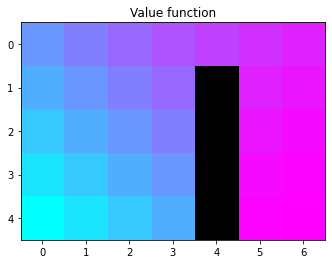

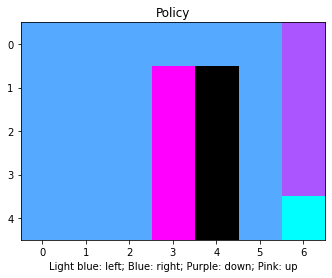

In [4]:
from algorithms.VI_dynamic_programming import value_iteration

expert_Q, expert_policy = value_iteration(env.P, env.R, env.gamma)

# Uncomment if you want to simulate the policy
# simulate_policy(expert_policy, f"../../videos/grid_world/{grid_type}_expert.mp4", env, HORIZON)

env.display_value_function(expert_Q)
env.display_policy(expert_Q)

In [3]:
env = set_granular_reward(env, expert_policy)

## Learninng from limited demonstation

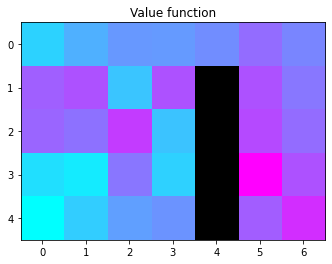

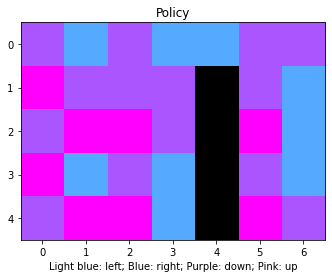

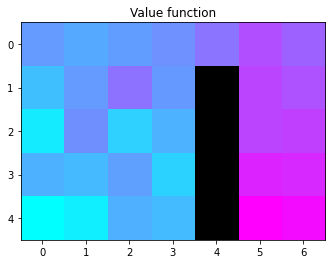

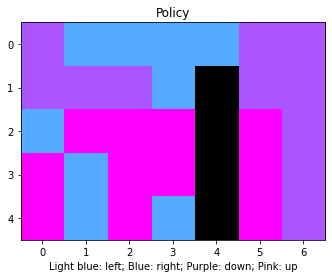

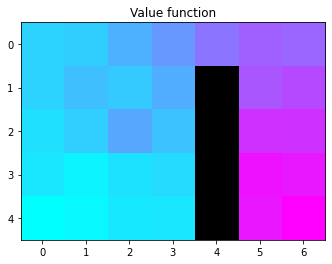

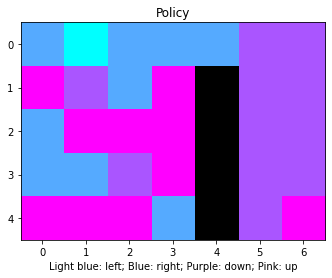

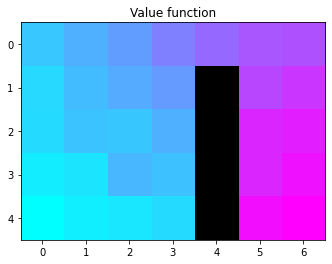

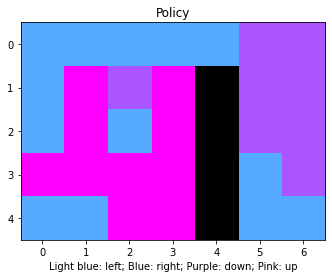

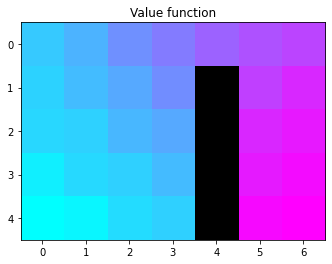

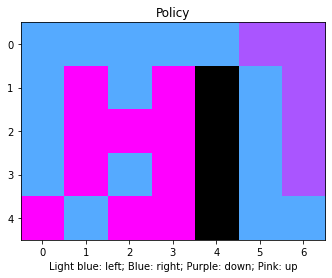

In [5]:
from algorithms.API.lstd import lstd_grid_word

n_expert_samples = 100
n_rl_samples = 500
regularisor = 0.00001
regularisor_bellmann = 0.00001
max_iteration = 5
epsilon_decay_limit = 0.2
regularisor_expert = 1
show_args = {"show_policy":True, "show_value_function": True, "show_statistics": False}

lstd_Q, lstd_policy, buffer_ = lstd_grid_word(env, n_expert_samples, n_rl_samples, regularisor, regularisor_bellmann, max_iteration=max_iteration, epsilon_decay_limit=epsilon_decay_limit, **show_args)

In [6]:
simulate_policy(lstd_policy, f"../../videos/grid_world/{grid_type}_lstd.mp4", env, HORIZON)

ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5233:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM default
ffmpeg version 4.3.3-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avres

## Deep Q-learning from Demonstration, tabular setting

End of expert phase


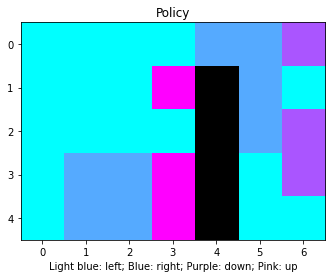

Beginning of rl phase


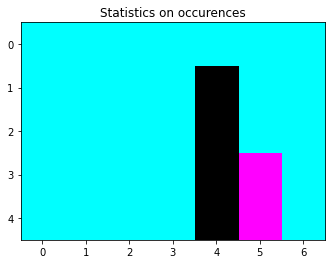

Max occurences 119.0


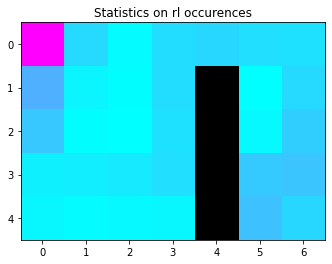

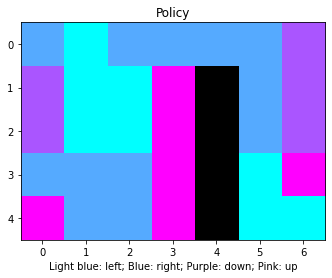

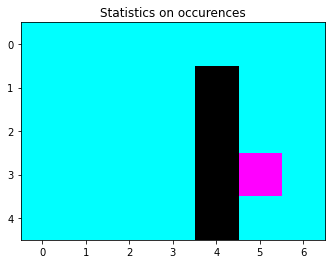

Max occurences 154.0


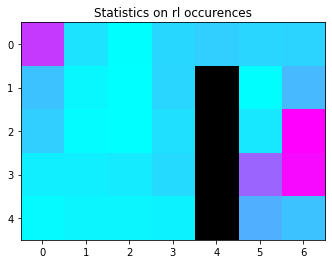

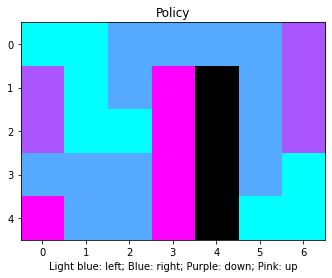

In [5]:
from algorithms.DQfD.tabular import tabular_DQfD

n_expert_trajectories = 8
n_step_td = 2
n_expert_iterations = 25
n_rl_iterations = 1000
epsilon_decay_limit = 0.2
update_target_frequency = 5
td_loss_weight = 1
n_td_loss_weight = 1
expert_weight = 1
diff_action_from_expert_penalisation = 0.8
show_args = {"show_policy":True, "show_value_function": False, "show_statistics": True, "display_frequency": 500}

DQfD_Q = tabular_DQfD(
    env,
    n_expert_trajectories,
    n_step_td,
    n_expert_iterations,
    n_rl_iterations,
    epsilon_decay_limit=epsilon_decay_limit,
    update_target_frequency=update_target_frequency,
    td_loss_weight=td_loss_weight,
    n_td_loss_weight=n_td_loss_weight,
    expert_weight=expert_weight,
    diff_action_from_expert_penalisation=diff_action_from_expert_penalisation,
    **show_args,
)

## Normalized Actor-Critic

In [6]:
import copy 

import numpy as np
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical


class SmallNAC(nn.Module):
    def __init__(self, env, entropy_weight):
        super(SmallNAC, self).__init__()
        self.env = env
        self.entropy_weight = entropy_weight

        self.net = nn.Sequential(
            nn.Linear(3, 50), nn.ReLU(), nn.Linear(50, 1)  # 2 for the state and 1 for the action  # 1 for Q(s, a)
        )

    def Q(self, state, action):
        (y, x) = self.env.index2coord[state]

        return self.net(torch.tensor([x, y, action], dtype=torch.float32))

    def V(self, state):
        v_value = 0

        for action in self.env._actions:
            v_value += torch.exp(self.Q(state, action) / self.entropy_weight)

        return self.entropy_weight * torch.log(v_value)

    def act(self, state):
        return self.pi_distribution(state).sample()

    def pi_distribution(self, state):
        pi_actions = torch.zeros((self.env.Na))

        for action in self.env._actions:
            pi_actions[action] = torch.exp((self.Q(state, action) - self.V(state)) / self.entropy_weight)

        categorical = Categorical(probs=pi_actions)

        return categorical

    def copy(self):
        return copy.deepcopy(self)

In [9]:
def get_losses(batch, model, target_model):
    actor_loss = 0
    critic_loss = 0

    for (state, action, reward, next_state) in batch:
        # Actor's loss
        q_require_grad = model.Q(state, action)
        v_require_grad = model.V(state)

        with torch.no_grad():
            v_target = target_model.V(next_state)
            entropy = model.pi_distribution(state).entropy()
        
        actor_loss += (q_require_grad - v_require_grad) * (reward + model.env.gamma * v_target - q_require_grad.detach())

        # Critic loss
        critic_loss += v_require_grad * (v_require_grad.detach() - (reward + model.env.gamma * v_target) + model.entropy_weight * entropy)

    return actor_loss / len(batch), critic_loss / len(batch)

In [27]:
class ReplayBuffer:
    def __init__(self, env, n_expert_samples, expert_policy):
        self.env = env

        self.buffer_expert = []
        self.buffer_rl = []

        if n_expert_samples > 0:  # i.e with Demonstration
            self.collect_expert_samples(n_expert_samples, expert_policy)

        self.rl_state = self.env.initial_state_distribution
        self.terminal = False

    def collect_expert_samples(self, n_samples, policy):
        state = self.env.initial_state_distribution

        self.env.reset()

        for idx_sample in range(n_samples):
            state = np.random.choice(self.env._states)
            self.env.state = state
            
            action = policy[state]

            next_state, reward, _, _ = self.env.step(action)

            self.buffer_expert.append((state, action, reward, next_state))

    def collect_rl_sample(self, model):
        if self.terminal:
            self.rl_state = self.env.initial_state_distribution
        self.env.state = self.rl_state

        action = model.act(self.env.state)

        next_state, reward, self.terminal, _ = self.env.step(action)

        self.buffer_rl.append((self.rl_state, action, reward, next_state))
        self.rl_state = next_state
    
    def get_batch(self, from_expert=True):
        if from_expert:
            return np.random.choice(self.buffer_expert)
        else:
            return np.random.choice(self.buffer_rl)

In [ ]:
import numpy as np


def nac(env, n_expert_samples, n_expert_iterations, n_rl_iterations, update_target_frequecy):
    # from algorithms.NAC.replay_buffer import ReplayBuffer
    # from algorithms.NAC.model import SmallNAC

    if n_expert_samples > 0:
        from algorithms.VI_dynamic_programming import value_iteration

        _, expert_policy = value_iteration(env.P, env.R, env.gamma)
    else:
        expert_policy = None
    
    replay_buffer = ReplayBuffer(
        env,
        n_expert_samples=n_expert_samples,
        expert_policy=expert_policy,
    )
    model = SmallNAC(env)
    target_model = model.copy()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for iteration in range(n_expert_iterations + n_rl_iterations):
        from_expert = True if iteration < n_expert_iterations else False

        if not from_expert:
            replay_buffer.collect_rl_sample(model)

        batch = replay_buffer.get_batch(from_expert=from_expert)

        actor_loss, critic_loss = get_losses(batch, model, target_model)
        loss = actor_loss + critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if iteration % update_target_frequecy == 0:
            target_model = model.copy()

    return model